# Mount Google Drive

In [1]:
#from google.colab import drive
#drive.mount('/gdrive')
#%cd /gdrive

# Import packages

In [2]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Load data

In [3]:
#load data
data=pd.read_csv('Data Sets/SAP.csv', delimiter=',')
data.info()

#remove columns we dont need
data = data.drop(data.columns[[2, 3, 4, 5]], axis=1)
#fill missing values
data['Open'].interpolate(method='index', inplace=True)
data['Volume'].interpolate(method='index', inplace=True)

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   Volume  1258 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 29.6+ KB


# Generate additional data

In [4]:
log_ret = np.diff(np.log(data['Open']))

sma10 = data['Open'].rolling(10).mean()
sma50 = data['Open'].rolling(50).mean()

ema10 = data['Open'].ewm(span=10, adjust=False).mean()
ema50 = data['Open'].ewm(span=50, adjust=False).mean()

#Note:
    # the sma
    # the ema
    # if sma 10 and ema 50 cross then


# Plot Data 

<Figure size 432x288 with 0 Axes>

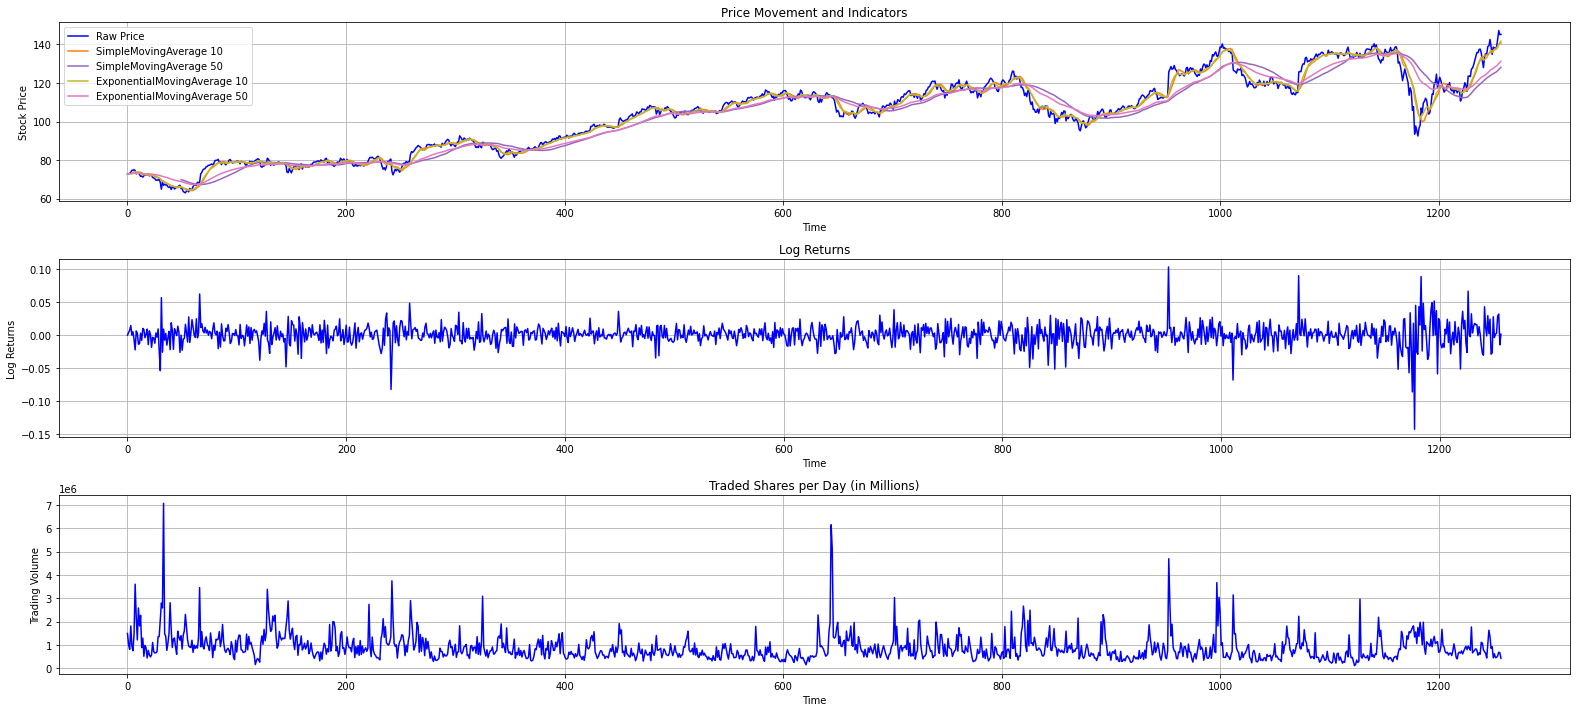

In [5]:
plt.clf()
fig = plt.figure(figsize=(22, 10))

plt.subplot(311)
plt.plot(data['Open'], color='b', label='Raw Price')
plt.plot(sma10, color='tab:orange', label='SimpleMovingAverage 10')
plt.plot(sma50, color='tab:purple', label='SimpleMovingAverage 50')
plt.plot(ema10, color='tab:olive', label='ExponentialMovingAverage 10')
plt.plot(ema50, color='tab:pink', label='ExponentialMovingAverage 50')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Price Movement and Indicators')
plt.grid()
plt.legend()

plt.subplot(312)
plt.plot(log_ret, color='b')
plt.xlabel('Time')
plt.ylabel('Log Returns')
plt.title('Log Returns')
plt.grid()

plt.subplot(313)
plt.plot(data['Volume'], color='b')
plt.xlabel('Time')
plt.ylabel('Trading Volume')
plt.title('Traded Shares per Day (in Millions)')

plt.tight_layout()
plt.grid()
plt.show()


# Add some generated data

In [6]:
#data['sma10'] = np.transpose(sma10)
#data['sma50'] = np.transpose(sma50)
#data['ema10'] = np.transpose(ema10)
#data['ema50'] = np.transpose(ema50)
#remove first 50 entries from data set so that we dont have only non-null elements
#data = data[50:]

data = data[1:]
data['log_ret'] = np.transpose(log_ret)


data.head()

,Date,Open,Volume,log_ret
1,2015-07-13,72.820000,1006400,-0.000275
2,2015-07-14,73.099998,816000,0.003838
3,2015-07-15,73.629997,1817800,0.007224
4,2015-07-16,74.690002,956100,0.014294
5,2015-07-17,74.680000,755000,-0.000134


# Split data

In [7]:
#split 80/20
training_size = int(0.8*len(data))
#input is previous price and previous volume
x_train = data.iloc[0:training_size-1, 1:4].values
x_test = data.iloc[training_size:-1, 1:4].values
#output is only next price
y_train = data.iloc[1:training_size, 1:2].values
y_test = data.iloc[training_size+1:, 1:2].values

print(x_train[1, :])
print(y_train[0, :])#shifted y_training data by 1
print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_test))


[7.30999980e+01 8.16000000e+05 3.83769665e-03]
[73.099998]
(1004, 3)
(1004, 1)
(251, 3)


# Normalize data

In [8]:
#### Normalization: 
    # Normalization AFTER splitting data 
    #As with all the transformations, it is important 
    #to fit the scalers to the training data only, 
    #not to the full dataset (including the test set). 
    #Only then can you use them to transform the training 
    #set and the test set (and new data).

#give x and y own scaler so we do not peek into the data and also preserve individual scaling
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

print(np.shape(x_train_scaled))
print(np.shape(y_train_scaled))
print(np.shape(x_test_scaled))
print(np.shape(y_test_scaled))

(1004, 3)
(1004, 1)
(251, 3)
(251, 1)


# Construct LSTM

In [9]:
#for reproducability of the results
np.random.seed(123)
tf.random.set_seed(123)

In [10]:
#LSTM input layer must be 3D, i.e. (samples, time steps, features)

x_train_scaled = np.reshape(x_train_scaled, (x_train_scaled.shape[0], 1, x_train_scaled.shape[1]))
x_test_scaled = np.reshape(x_test_scaled, (x_test_scaled.shape[0], 1, x_test_scaled.shape[1]))

print(np.shape(x_train_scaled))
print(np.shape(x_test_scaled))

(1004, 1, 3)
(251, 1, 3)


In [11]:
#create model
model = Sequential()
model.add(LSTM(50, input_shape = (x_train_scaled.shape[1], x_train_scaled.shape[2]), return_sequences=True))#initialize LSTM by passing input shape; always return sequences between LSTM layers
model.add(LSTM(10, dropout=0.2))#add dropout against possible overfitting
model.add(Dense(3, activation='relu'))#dense layer compresses input to output #create higher order polynomial by stacking dense layers
model.add(Dense(2, activation='relu'))#dense layer compresses input to output 
model.add(Dense(1, activation='relu'))#dense layer compresses input to output 
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             10800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                2440      
_________________________________________________________________
dense (Dense)                (None, 3)                 33        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 8         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 13,284
Trainable params: 13,284
Non-trainable params: 0
_________________________________________________________________


# Fit model on training data

In [12]:
#fit model to training data
history = model.fit(x_train_scaled, y_train_scaled, 
            epochs=21, batch_size=25,#how many times do we run the model and how many instances do we pass each step (32 is general starting point, generally start with 32/64/128/256/1024)
            validation_split = 0.1, #splits training data into another validation set
            verbose=1) #returns state for each epoche

Epoch 1/21
37/37 [==============================] - 1s 18ms/step - loss: 0.1516 - val_loss: 0.2715
Epoch 2/21
37/37 [==============================] - 0s 3ms/step - loss: 0.0436 - val_loss: 0.0519
Epoch 3/21
37/37 [==============================] - 0s 3ms/step - loss: 0.0269 - val_loss: 0.0565
Epoch 4/21
37/37 [==============================] - 0s 3ms/step - loss: 0.0200 - val_loss: 0.0331
Epoch 5/21
37/37 [==============================] - 0s 2ms/step - loss: 0.0135 - val_loss: 0.0134
Epoch 6/21
37/37 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0030
Epoch 7/21
37/37 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 8/21
37/37 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 9/21
37/37 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 8.5919e-04
Epoch 10/21
37/37 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 8.5296e-04
Epoch 11/2

# Get forecast from test data

In [13]:
#get forecast from applying model to test data
prediction = model.predict(x_test_scaled)
x_test_scaled = x_test_scaled.reshape((x_test_scaled.shape[0], x_test_scaled.shape[2]))
prediction = y_scaler.inverse_transform(prediction)

# Visualize model Performance

<Figure size 432x288 with 0 Axes>

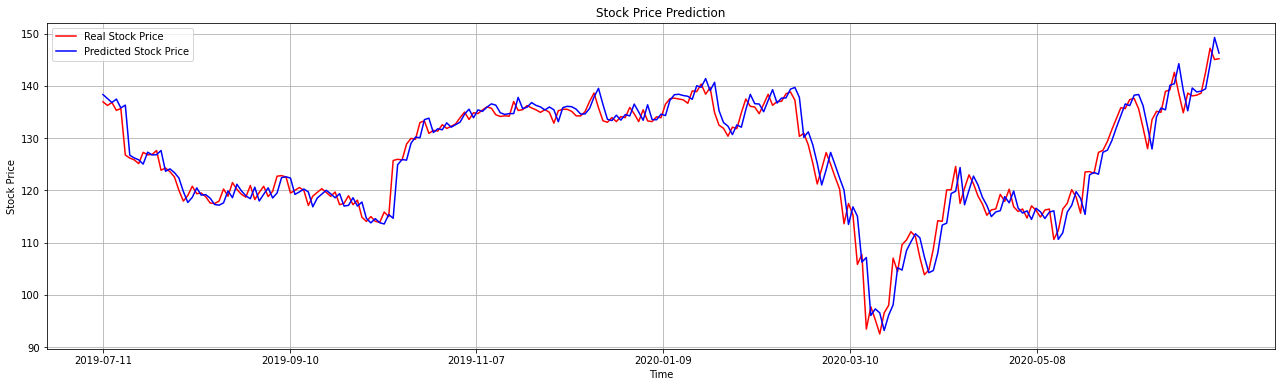

In [14]:
time = data.loc[training_size+1+1:, 'Date']#plot all available points, e.g. for last 30days use [-30:] and adjust y_test and prediction accordingly when calling the plot

plt.clf()
fig = plt.figure(figsize=(22, 6))

plt.plot(time, y_test, color = 'r', label = 'Real Stock Price')
plt.plot(time, prediction, color = 'b', label = 'Predicted Stock Price')
plt.xticks(np.arange(0,len(time),len(time)/6))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.grid()
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

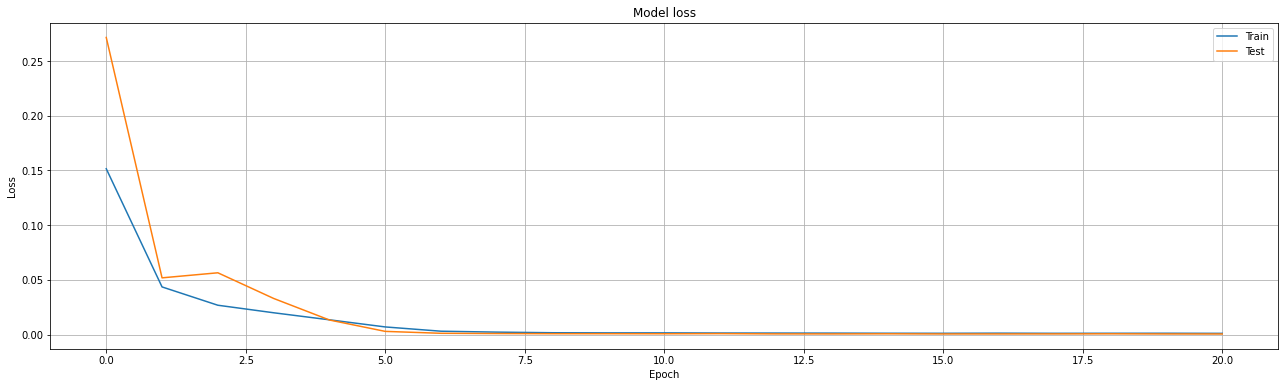

In [15]:
plt.clf()
fig = plt.figure(figsize=(22, 6))

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

The calculated indicators did not add any performance to the model so that in the end we only use the lagged price, the volume and the logged returns as features